<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/ML/report_AM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE

In [0]:
import statsmodels.api as sm

In [0]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6

In [0]:
dados = pd.read_csv('airline.txt', header=None)

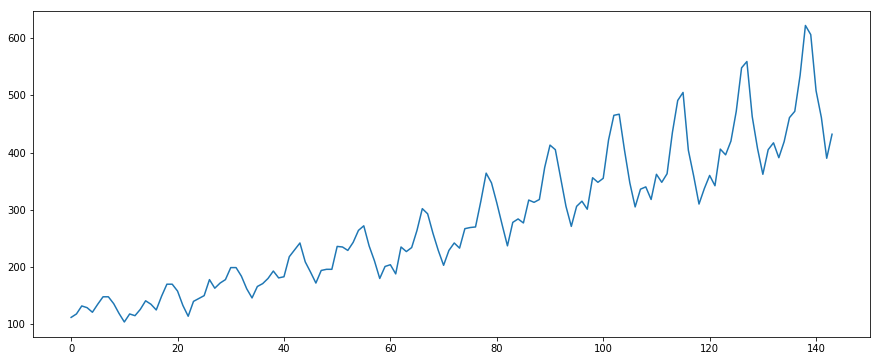

In [8]:
plt.plot(dados)
plt.show()

In [0]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [0]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [0]:
serie = dados.values
serie_normalizada = normalizar_serie(serie)

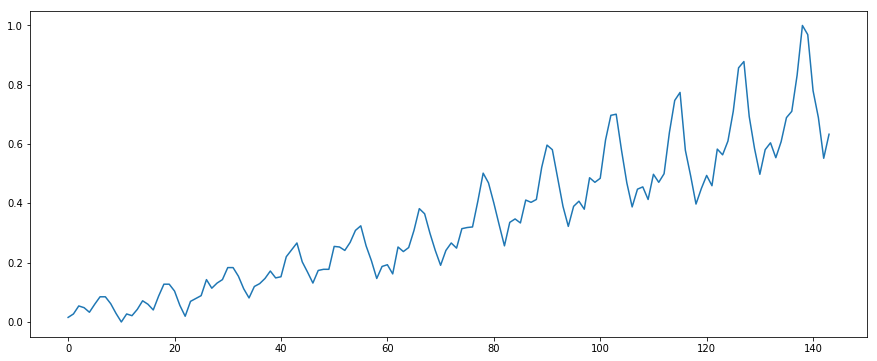

In [12]:
plt.plot(serie_normalizada)
plt.show()

In [0]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [0]:
qtd_lags = 5
janelas = gerar_janelas(5, serie_normalizada)

In [15]:
janelas.shape

(138, 6)

In [0]:
def diferenciar_serie(serie):
    #serie: obj pandas
    return serie.diff().dropna()

In [0]:
def incrementar_serie(serie_real, serie_diff):
    return serie_real[0:-1] + serie_diff

In [0]:
serie_diff = diferenciar_serie(dados)

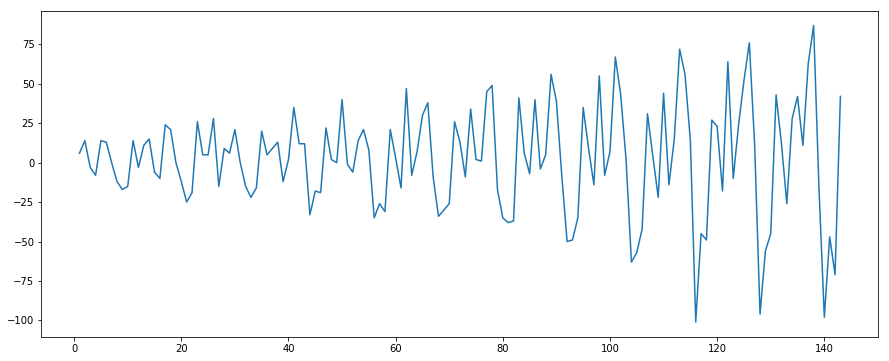

In [19]:
plt.plot(serie_diff)
plt.show()

In [0]:
serie_rt = incrementar_serie(dados.values, serie_diff.values)

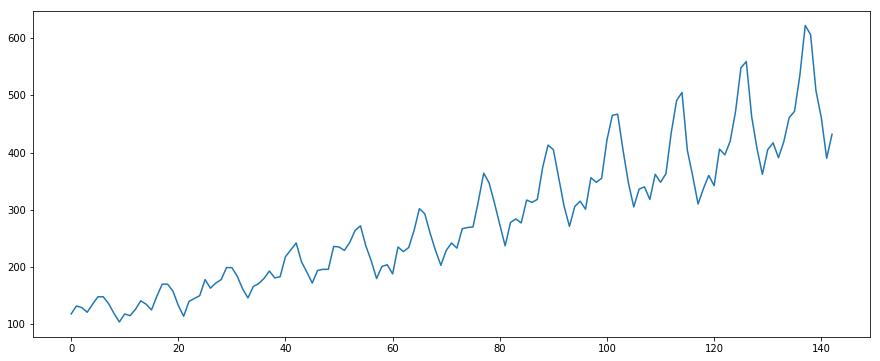

In [21]:
plt.plot(serie_rt)
plt.show()

In [0]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

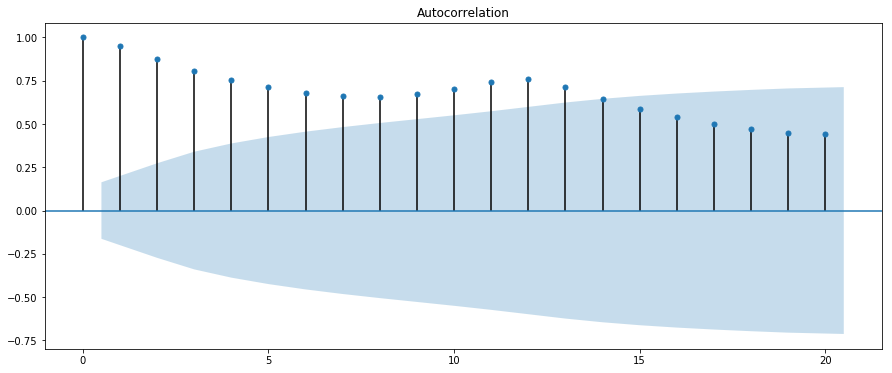

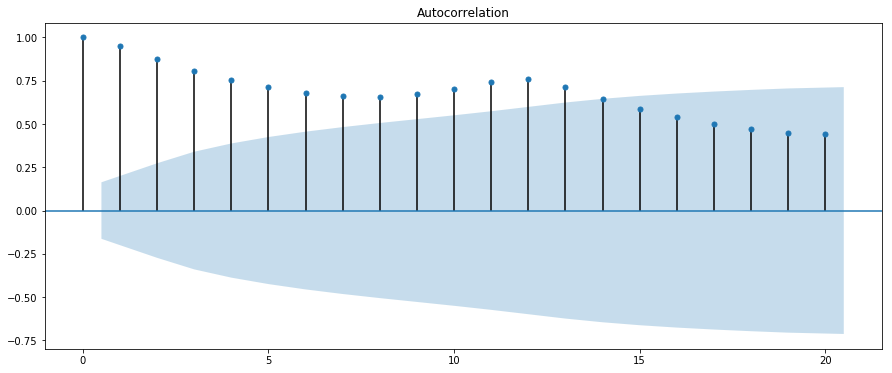

In [23]:
sm.graphics.tsa.plot_acf(serie_normalizada, lags=20)

In [24]:
lag_sel = select_lag_acf(serie_normalizada, 20)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [25]:
lag_sel

[19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6]

## Split serie with lags

In [0]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [0]:
tam_janela = 20
serie_janelas = gerar_janelas(tam_janela, serie_normalizada)

In [47]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.50, perc_val = 0.25)

Particao de Treinamento: 0 61
Particao de Validacao: 61 91
Particao de Teste: 91 123


## MLP train

In [0]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec, func_act):
    
    # Grid
    neuronios =  [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    func_activation = [func_act] #  ['tanh', 'relu']
    alg_treinamento = ['lbfgs', 'adam']
    max_iteracoes = [10000]
    learning_rate = ['constant', 'adaptive']
    
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela 
                            
                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])

                            for e in range(0, num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                                
                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    print('Melhor MSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag
    
    
    return select_model, qtd_lags_sel

## Tanh x Relu

In [49]:
modelo_tanh, lag_sel_tanh = treinar_mlp(x_train, y_train, x_val, y_val, 5, 'tanh')

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.005031597951876592
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.004911132944798491
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.004639786742987499
Melhor MSE: 0.004362638834450514
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.004040527255715248
Melhor MSE: 0.0039046509455868197
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.0038317191773488417
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.0037255923515008157
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.002898243624036666
Melhor MSE: 0.002853209443459972
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.002610297841608659
Melhor MSE: 0.0021478125239700126
Melhor MSE: 0.001154249172940131
QTD de Lags: 12 Qtd de Neu

In [50]:
modelo_relu, lag_sel_relu = treinar_mlp(x_train, y_train, x_val, y_val, 5, 'relu')

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.004954505403645284
Melhor MSE: 0.004927980034830781
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.00439072768805794
Melhor MSE: 0.004376573201630607
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.00436121239985383
Melhor MSE: 0.004341161120315126
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.0037885544032265793
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.0035636948257194443
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.0026083300366202904
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.0008760331741494656
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.0004456457030

## Experiments

In [56]:
from sklearn.base import clone

mse_relu = []
mse_tanh = []

for e in range(0, 30):
  # relu
  mlp_relu = clone(modelo_relu)
                                
  mlp_relu.fit(x_train[:,-lag_sel_relu:], y_train)
  predict_validation = mlp_relu.predict(x_val[:,-lag_sel_relu:])
  mse = MSE(y_val, predict_validation)
  
  mse_relu.append(mse)
  
  # tanh
  mlp_tanh = clone(modelo_tanh)
                                
  mlp_tanh.fit(x_train[:,-lag_sel_tanh:], y_train)
  predict_validation = mlp_tanh.predict(x_val[:,-lag_sel_tanh:])
  mse = MSE(y_val, predict_validation)
  
  mse_tanh.append(mse)
  
print(mse_relu)
print(mse_tanh)

[0.0002804675171840536, 0.000932277704439485, 0.00035012184551946104, 0.06851270967116299, 0.00029933068302314666, 0.0685127339831624, 0.06851273025630542, 0.06876620055359337, 0.06851273644050929, 0.0006279354567265608, 0.06851273647704698, 0.001944310781804723, 0.001967704600760983, 0.06855195521657244, 0.06851273644768315, 0.06851273643980518, 0.06851273646791033, 0.0004403600833772606, 0.06851273451451947, 0.06851273644135523, 0.00029207223433904013, 0.058613517024031885, 0.0685127364451266, 0.0685544076346812, 0.0005404544407748755, 0.0007168515832109748, 0.06851272894186736, 0.06743339962786929, 0.06851273644111659, 0.006841030953748211]
[0.0008991894937020567, 0.0003236391388438483, 0.0008183432975625294, 0.00033061042364278384, 0.0004753943912255102, 0.000409200584729378, 0.00044735575849787885, 0.0003716170876886741, 0.0005609091761268209, 0.0012952954122200315, 0.0002655751240019499, 0.0009377826928640874, 0.0005223888306318596, 0.0006111601530865891, 0.0002673732734927187, 0

In [64]:
print('Tanh\t mean=%f, std=%f, max=%f' % (np.mean(mse_tanh), np.std(mse_tanh), np.min(mse_tanh)))
print('Relu\t mean=%f, std=%f, max=%f' % (np.mean(mse_relu), np.std(mse_relu), np.min(mse_relu)))

Tanh	 mean=0.000614, std=0.000362, max=0.000168
Relu	 mean=0.041261, std=0.032719, max=0.000280


## teste

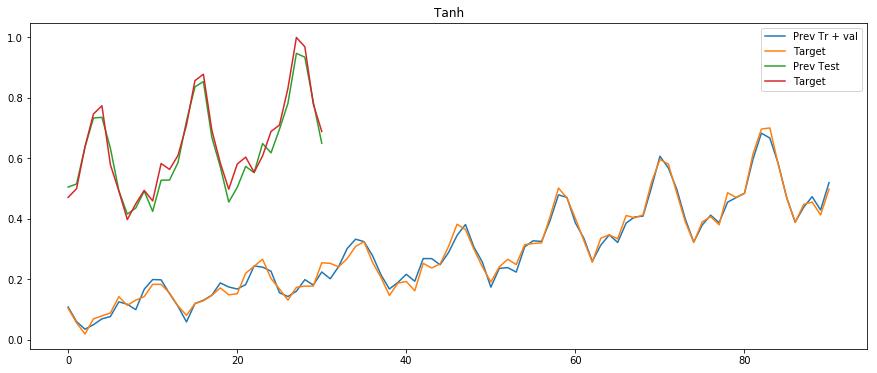

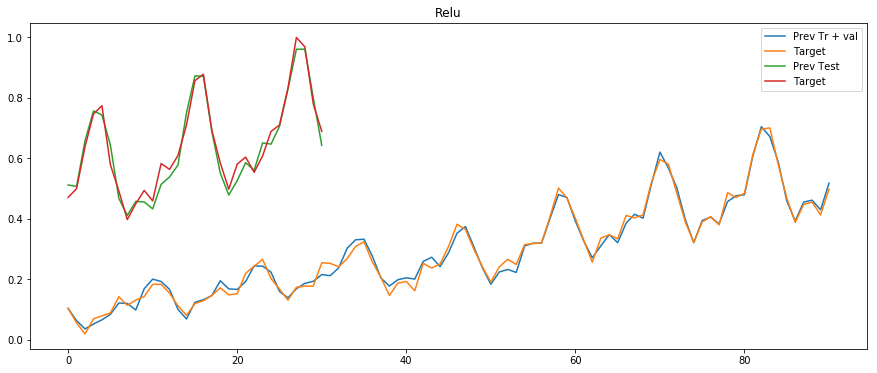

In [67]:
for name, modelo, lag_sel in [('Tanh', modelo_tanh, lag_sel_tanh), ('Relu', modelo_relu, lag_sel_relu)]:

  predict_train = modelo.predict(x_train[:, -lag_sel:])
  predict_val = modelo.predict(x_val[:, -lag_sel:])
  predict_test = modelo.predict(x_test[:, -lag_sel:])

  previsoes_train = np.hstack(( predict_train, predict_val))
  target_train = np.hstack((y_train, y_val))
  
  plt.plot(previsoes_train, label = 'Prev Tr + val')
  plt.plot(target_train, label='Target')
  plt.legend(loc='best')
  # plt.show()
  
  plt.plot(predict_test, label = 'Prev Test')
  plt.plot(y_test, label='Target')
  plt.legend(loc='best')
  plt.title(name)
  plt.show()